In [1]:
import os
import cv2
import numpy as np

# Define dataset root directory
dataset_root = r"C:\Users\Major Project\data"  # Change this to the actual path
processed_dir = r"C:\Users\Major Project\processed_dir"  # Folder to store processed images
os.makedirs(os.path.join(processed_dir, "images"), exist_ok=True)

def find_images(root_dir):
    data = []  # Store image paths and labels
    
    # Recursively walk through all subdirectories
    for root, _, files in os.walk(root_dir):
        images = [f for f in files if f.endswith(".bmp")]
        
        for img in images:
            img_path = os.path.join(root, img)
            
            # Determine label based on folder name
            label = 0 if "Grupo_0" in root else 1  # Non-Alcoholic: 0, Alcoholic: 1
            
            data.append({"image": img_path, "label": label})
    
    return data

def process_images(root_dir):
    dataset_info = find_images(root_dir)
    processed_data = []
    
    for item in dataset_info:
        img_path = item["image"]
        label = item["label"]
        
        # Load image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        # Save processed image
        img_filename = os.path.basename(img_path).replace(".bmp", ".png")
        img_save_path = os.path.join(processed_dir, "images", img_filename)
        cv2.imwrite(img_save_path, image)
        
        processed_data.append({"image": img_save_path, "label": label})
    
    return processed_data

# Run dataset processing
processed_dataset = process_images(dataset_root)
print(f"Processed {len(processed_dataset)} images and saved them in '{processed_dir}/images'.")


Processed 25259 images and saved them in 'C:\Users\Major Project\processed_dir/images'.


In [2]:
import os
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision import models

# Define paths
processed_dir = r"C:\Users\Major Project\processed_dir"
feature_dir = r"C:\Users\Major Project\feature_dir"
os.makedirs(feature_dir, exist_ok=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Pretrained VGG16 Model
model = models.vgg16(pretrained=True).to(device)
model.eval()  # Set to evaluation mode

# Define preprocessing transforms
transform = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image):
    """Extract deep features from an image using VGG16 in PyTorch"""
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    with torch.no_grad():  # No gradients needed
        features = model.features(image)
    return features.cpu().numpy().flatten()

def process_images(batch_size=32):
    features_list = []
    labels_list = []
    
    for root, _, files in os.walk(processed_dir):  
        for img_name in files:
            img_path = os.path.join(root, img_name)
            label = 0 if "Grupo_0" in img_path else 1  # Label assignment
            
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            features = extract_features(image)
            features_list.append(features)
            labels_list.append(label)
            
    # Convert to numpy arrays
    features_array = np.array(features_list)
    labels_array = np.array(labels_list)

    # Save extracted features & labels
    np.save(os.path.join(feature_dir, "features.npy"), features_array)
    np.save(os.path.join(feature_dir, "labels.npy"), labels_array)

    print(f"Extracted features from {len(features_list)} images and saved them in '{feature_dir}'.")

# Run feature extraction
process_images()


Using device: cuda


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted features from 22334 images and saved them in 'C:\Users\Major Project\feature_dir'.


In [3]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load extracted features and labels
feature_dir = r"C:\Users\Major Project\feature_dir"
features = np.load(f"{feature_dir}/features.npy")
labels = np.load(f"{feature_dir}/labels.npy")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

# Train LightGBM model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data])

# Save the trained model
bst.save_model("lightgbm_model.txt") 

# Extract leaf indices as features
train_leaf_indices = bst.predict(X_train, pred_leaf=True)
test_leaf_indices = bst.predict(X_test, pred_leaf=True)

# Save leaf features
np.save(f"{feature_dir}/train_leaf_features.npy", train_leaf_indices)
np.save(f"{feature_dir}/test_leaf_features.npy", test_leaf_indices)

# Make predictions
y_pred = bst.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy:.4f}")
print("Extracted and saved LightGBM leaf features.")


Model Accuracy: 1.0000
Extracted and saved LightGBM leaf features.


In [4]:
import cv2
import lightgbm as lgb
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model for feature extraction
base_model = VGG16(weights="imagenet", include_top=False)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Load the trained LightGBM model
bst = lgb.Booster(model_file="lightgbm_model.txt")

def predict_image(image_path):
    """Extract features from an image and classify as Alcoholic or Non-Alcoholic"""
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)  # Shape: (1, 224, 224, 3)
    
    # Extract features using VGG16
    features = feature_extractor.predict(image)  # Shape: (1, 7, 7, 512)
    features = features.reshape(1, -1)  # Flatten to (1, N)
    
    # Predict using LightGBM
    prediction = bst.predict(features)[0]  # Extract the first prediction
    
    # Assign labels based on threshold
    label = "Non-Alcoholic" if prediction < 0.5 else "Alcoholic"
    print(f"Predicted label: {label}")

# Test with a new image
test_image_path = r"C:\Users\Major Project\data\Grupo_2\E_2_0\Iritech\E_2_0_0\E_2_0_0_L_5\E_2_0_0_L_M_N_N_1979_0_2017.bmp"
predict_image(test_image_path)


1/1 [==============================] - 0s 414ms/step
Predicted label: Alcoholic


In [5]:
import os
import json
import cv2
import numpy as np

# Define paths
dataset_folder = r"C:\Users\Major Project\data"  # Dataset location
segmentation_dir = r"C:\Users\Major Project\segmentation_dir"  # Directory to store generated masks

# Ensure segmentation directory exists
os.makedirs(segmentation_dir, exist_ok=True)

def load_json_data(json_file_path):
    """Load JSON file."""
    with open(json_file_path, 'r') as jsonfile:
        return json.load(jsonfile)

def extract_segments(json_data):
    """Extract iris segmentation data."""
    segments = {}
    for img in json_data:
        val = json_data[img]
        regions = val.get('regions', [])
        for region in regions:
            shape_attributes = region.get('shape_attributes', {})
            region_attributes = region.get('region_attributes', {})

            if region_attributes.get('Eye') == 'iris':
                x_points = shape_attributes.get('all_points_x', [])
                y_points = shape_attributes.get('all_points_y', [])
                if x_points and y_points:
                    segments[val['filename']] = list(zip(x_points, y_points))
    return segments

def generate_mask(image_shape, coordinates):
    """Generate binary mask from segmentation coordinates."""
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if coordinates:
        cv2.fillPoly(mask, [np.array(coordinates, dtype=np.int32)], 255)
    return mask

def process_json_files(dataset_folder, segmentation_dir):
    """Process all JSON files and save masks."""
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                json_data = load_json_data(json_file_path)
                segments = extract_segments(json_data)

                for filename, coordinates in segments.items():
                    image_path = os.path.join(root, filename)
                    if os.path.exists(image_path):
                        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        mask = generate_mask(image.shape, coordinates)

                        # Save mask
                        mask_filename = os.path.splitext(filename)[0] + "_mask.png"
                        mask_path = os.path.join(segmentation_dir, mask_filename)
                        cv2.imwrite(mask_path, mask)
                        print(f"Saved mask: {mask_path}")

# Run mask generation process
process_json_files(dataset_folder, segmentation_dir)
print("All masks generated and saved successfully!")


Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_0_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_R_M_N_N_1981_0_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_0_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_1_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_2_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_3_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_4_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_5_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_6_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_7_2017_mask.png
Saved mask: C:\Users\Major Project\segmentation_dir\E_0_0_0_L_M_N_N_1981_8_2017_mask.png
Saved mask: C:\Users\

In [6]:
import os
import cv2
import numpy as np

# Paths
dataset_folder = r"C:\Users\Major Project\data"  # Original dataset
segmentation_dir = r"C:\Users\Major Project\segmentation_dir"  # Folder with generated masks
segmented_images_dir = r"C:\Users\Major Project\segmented_images"  # Output directory for segmented images

# Ensure output directory exists
os.makedirs(segmented_images_dir, exist_ok=True)

def apply_mask_to_image(image, mask):
    """Applies a binary mask to an image."""
    return cv2.bitwise_and(image, image, mask=mask)

def process_images(dataset_folder, segmentation_dir, segmented_images_dir):
    """Applies masks to images and saves segmented images."""
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith(('.jpg', '.png', '.bmp')):  # Process only image files
                image_path = os.path.join(root, file)
                mask_filename = os.path.splitext(file)[0] + "_mask.png"
                mask_path = os.path.join(segmentation_dir, mask_filename)

                if os.path.exists(mask_path):  # Ensure mask exists
                    image = cv2.imread(image_path)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    if image is not None and mask is not None:
                        segmented_image = apply_mask_to_image(image, mask)

                        # Maintain directory structure
                        relative_path = os.path.relpath(root, dataset_folder)
                        save_path = os.path.join(segmented_images_dir, relative_path)
                        os.makedirs(save_path, exist_ok=True)

                        # Save segmented image
                        output_filename = os.path.join(save_path, file)
                        cv2.imwrite(output_filename, segmented_image)
                        print(f"Saved segmented image: {output_filename}")

# Run the process
process_images(dataset_folder, segmentation_dir, segmented_images_dir)
print("All segmented images saved successfully!")


Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_M_N_N_1981_0_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_R_M_N_N_1981_0_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_5\E_0_0_0_L_M_N_N_1981_0_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_5\E_0_0_0_L_M_N_N_1981_10_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_5\E_0_0_0_L_M_N_N_1981_11_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_5\E_0_0_0_L_M_N_N_1981_12_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_images\Grupo_0\E_0_0\IriTech\E_0_0_0\E_0_0_0_L_5\E_0_0_0_L_M_N_N_1981_13_2017.bmp
Saved segmented image: C:\Users\Major Project\segmented_image

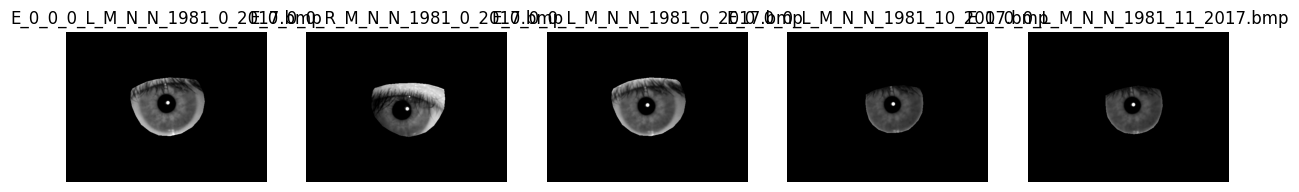

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to segmented images
segmented_images_dir = r"C:\Users\Major Project\segmented_images"

def find_all_images(folder_path):
    """ Recursively find all image files in deeply nested subfolders. """
    image_paths = []
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith((".bmp", ".jpg", ".jpeg")):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

    return image_paths

# Get all images
all_images = find_all_images(segmented_images_dir)

# Display images
def show_images(image_paths, num_images=5):
    """ Show first 'num_images' images from the list. """
    num_images = min(num_images, len(image_paths))  # Avoid index error

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        image = cv2.imread(image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(image_paths[i]))

    plt.show()

# Run display function
if all_images:
    show_images(all_images, num_images=5)
else:
    print("No images found!")



In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
segmented_images_dir = r"C:\Users\Major Project\segmented_images"

# Define transformations (Resize and Normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor(),  # Convert to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize
])

# Load dataset
dataset = datasets.ImageFolder(root=segmented_images_dir, transform=transform)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Debugging: Check if images are loading
print(f"Total images found: {len(dataset)}")


Using device: cuda
Total images found: 13469


In [27]:
import numpy as np

features = np.load("cnn_features.npy")
labels = np.load(r"C:\Users\Major Project\feature_dir\labels.npy")

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (13469, 32768)
Labels shape: (22334,)


In [31]:
import numpy as np

features = np.load("cnn_features.npy")
labels = np.load(r"C:\Users\Major Project\feature_dir\labels.npy")

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (13469, 32768)
Labels shape: (22334,)


In [32]:
min_len = min(len(features), len(labels))

features_fixed = features[:min_len]
labels_fixed = labels[:min_len]

print("Fixed Features shape:", features_fixed.shape)
print("Fixed Labels shape:", labels_fixed.shape)

np.save("fixed_cnn_features.npy", features_fixed)
np.save("fixed_labels.npy", labels_fixed)

print("✅ Fixed! Now retry train_test_split.")


Fixed Features shape: (13469, 32768)
Fixed Labels shape: (13469,)
✅ Fixed! Now retry train_test_split.


In [ ]:
import numpy as np

features_fixed = features_fixed.astype(np.float16)

print("New Features dtype:", features_fixed.dtype)  # Should print float16


MemoryError: Unable to allocate 842. MiB for an array with shape (13469, 32768) and data type float16

: 

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_fixed, labels_fixed, test_size=0.2, random_state=42)

print("✅ Data split successfully!")


MemoryError: Unable to allocate 1.32 GiB for an array with shape (10775, 32768) and data type float32

In [29]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image

# ✅ DEVICE SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ DATASET CLASS (Only Loads Images)
class ImageDataset(Dataset):
    def __init__(self, image_root, transform=None):
        self.image_paths = []
        self.transform = transform

        for root, _, files in os.walk(image_root):
            for file in files:
                if file.endswith((".bmp", ".jpg", ".jpeg")):
                    self.image_paths.append(os.path.join(root, file))

        if len(self.image_paths) == 0:
            raise ValueError("❌ No images found! Check directory paths.")

        print(f"✅ Found {len(self.image_paths)} images.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

# ✅ DEFINE TRANSFORMS (Reduce Image Size)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Reduce to 128x128
    transforms.ToTensor(),
])

# ✅ SET DATA PATH
segmented_images_dir = r"C:\Users\Major Project\segmented_images"  # CHANGE THIS

# ✅ CREATE DATASET & DATALOADER
dataset = ImageDataset(segmented_images_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# ✅ MODIFY SIMPLECNN FOR FEATURE EXTRACTION
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 256 -> 128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # 128 -> 64
        )
        
        self.flatten = nn.Flatten()  # Flatten feature maps

    def forward(self, x):
        encoded = self.encoder(x)
        return self.flatten(encoded)  # Output feature vector

# ✅ CREATE MODEL
model = FeatureExtractorCNN().to(device)
model.eval()  # Set to evaluation mode (no training)

# ✅ EXTRACT FEATURES
features_list = []
for img in dataloader:
    img = img.to(device)
    with torch.no_grad():
        features = model(img)
        features_list.append(features.cpu().numpy())

# Convert features to numpy array
features = np.vstack(features_list)
np.save("cnn_features.npy", features)
print("✅ Feature extraction complete!")

# ✅ LOAD LABELS (Replace with your actual label loading method)
labels = np.load(r"C:\Users\Major Project\feature_dir\labels.npy")  # Ensure labels match feature count

# ✅ SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)



# ✅ TRAIN LIGHTGBM MODEL
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, test_data])

# ✅ SAVE TRAINED MODEL
bst.save_model("FeatureExtractorCNN.pth")

# ✅ MAKE PREDICTIONS
y_pred = bst.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# ✅ EVALUATE ACCURACY
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy:.4f}")


✅ Found 13469 images.
✅ Feature extraction complete!


ValueError: Found input variables with inconsistent numbers of samples: [13469, 22334]

In [ ]:
torch.save(model.state_dict(), "FeatureExtractorCNN.pth")
print("✅ Model saved as featureExtracterCNN.pth")


✅ Model saved as SimpleCNN.pth


In [3]:
model.load_state_dict(torch.load("SimpleCNN.pth"))
model.eval()  # Set to evaluation mode


FeatureExtractorCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [5]:
print("Expected Features:", lgb_model.num_feature())
print("Input Features Shape:", features.shape)


Expected Features: 25088
Input Features Shape: (13469, 32768)


In [1]:
import lightgbm as lgb
import numpy as np

# Load LightGBM model
lgb_model = lgb.Booster(model_file="lightgbm_model.txt")

# Extract features
lgb_features = lgb_model.predict(features, pred_leaf=True)  # Get leaf indices
lgb_features = np.array(lgb_features)

print("✅ LightGBM Features Extracted:", lgb_features.shape)


NameError: name 'features' is not defined

show alcoholic with the probabilty